# Modelling Exercises

## Exercise 1: Model Selection

Today we are working with the `California Housing dataset`, which you are already familiar with, as we previously used it while exploring resampling method.
This dataset is based on the 1990 U.S. Census and includes features describing California districts. 

1) Familiarize yourself with the data
    - What kind of features are in the dataset? What is the target?
2) Baseline model 
    - Create a baseline linear regression model using **all** features and evaluate the model through 5-fold cross validation, using R² as the performance metric
    - Print the individual and average R²
3) Apply a forward stepwise selection to find a simpler suitable model.
    - Split the data into 80% training data and 20% testing data (print the shape to confirm it was sucessful)
    - Perform a forward stepwise selection with a linear regression model, 5-fold CV, R² score, and `parsimonious` feature selection (refer to [documentation](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/) for further information)
    - Print the best CV R² as well as the chosen features
4) Evaluate the model on the test set

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# 1) Load the California housing dataset
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target


# 2) Create baseline model 
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Print the results
print("R² scores from each fold:", scores)
print("Average R² score:", np.mean(scores))


# 3) Apply a forward stepwise selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Forward Sequential Feature Selector
sfs_forward = SequentialFeatureSelector(
    estimator=LinearRegression(),
    k_features="parsimonious",
    forward=True,
    floating=False,
    scoring='r2',
    cv=5,
    verbose=0)

sfs_forward.fit(X_train, y_train)

print(f">> Forward SFS:")
print(f"   Best CV R²      : {sfs_forward.k_score_:.3f}")
print(f"   Optimal # feats : {len(sfs_forward.k_feature_idx_)}")
print(f"   Feature names   : {sfs_forward.k_feature_names_}")


# 4) Evaluate the model
selected_features = list(sfs_forward.k_feature_names_)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train and evaluate
model.fit(X_train_selected, y_train)
test_r2 = model.score(X_test_selected, y_test)
print(f"Test R² for the sfs model: {test_r2:.4f}")

R² scores from each fold: [0.54866323 0.46820691 0.55078434 0.53698703 0.66051406]
Average R² score: 0.5530311140279571
(16512, 8) (4128, 8)
(16512,) (4128,)
>> Forward SFS:
   Best CV R²      : 0.612
   Optimal # feats : 7
   Feature names   : ('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude')
Test R² for the sfs model: 0.5757


## Exercise 2: LASSO

Please implement a Lasso regression model similar to the Ridge model in the [Regularization](2_Regularization) section.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Data related processing
hitters = sm.datasets.get_rdataset("Hitters", "ISLR").data
hitters_subset = hitters[["Salary", "AtBat", "Runs","RBI", "CHits", "CAtBat", "CRuns", "CWalks", "Assists", "Hits", "HmRun", "Years", "Errors", "Walks"]].copy()
hitters_subset = hitters_subset.drop(columns=["CRuns", "CAtBat"]) # Remove highly correlated features (see previous session)
hitters_subset.dropna(inplace=True) # drop rows containing missing data

y = hitters_subset["Salary"]
X = hitters_subset.drop(columns=["Salary"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler() # Scale predictors to mean=0 and std=1
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Lasso 
lambda_range = np.linspace(0.001, 20, 100) 

# Get the optimal lambda
lasso_cv = LassoCV(alphas=lambda_range)
lasso_cv.fit(X_train_scaled, y_train) 

print(f"Optimal alpha: {lasso_cv.alpha_}\n")

# Get training R²
train_score_ridge= lasso_cv.score(X_train_scaled, y_train)
print(f"Training R²: {train_score_ridge}\n")

# Put the coefficients into a nicely formatted df for visualization
coef_table = pd.DataFrame({
    'Predictor': X_train.columns,
    'Beta': lasso_cv.coef_
})

coef_table = coef_table.reindex(coef_table['Beta'].abs().sort_values(ascending=False).index)
print(coef_table, "\n")


test_score_ridge= lasso_cv.score(X_test_scaled, y_test)
print(f"Test R²: {test_score_ridge}")

Optimal alpha: 20.0

Training R²: 0.47908195299121104

   Predictor        Beta
3      CHits  177.984173
6       Hits  101.982447
7      HmRun   52.177420
10     Walks   41.664953
2        RBI    0.000000
0      AtBat    0.000000
1       Runs    0.000000
5    Assists   -0.000000
4     CWalks    0.000000
8      Years    0.000000
9     Errors   -0.000000 

Test R²: 0.31479649243077035


## Exercise 3: Principal Component Analysis

 For today’s practical session, we will work with the **Diabetes** dataset built into `scikit-learn`. This dataset contains medical information from 442 diabetes patients:

* **Features (X):** 10 baseline variables (age, sex, BMI, average blood pressure, and six blood serum measures).
* **Target (y):** a quantitative measure of disease progression one year after baseline.

You can read more here: [https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load\_diabetes.html](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)

**Tasks:**

1. **Inspect & clean (already implemented)**

   * Display summary statistics (`df.describe()`) for all 10 features.
   * Check for missing values. (Hint: this dataset has none, but verify.)

2. **Standardize**

   * Use `StandardScaler()` to transform each feature to mean 0, variance 1.

3. **PCA & scree plot**

   * Fit `PCA()` to the standardized feature matrix.
   * Plot the **explained variance ratio** for each principal component (a scree plot).
   * Decide how many components to retain (e.g.\ cumulative variance ≥ 80%).

4. **Interpret loadings**

   * Examine `pca.components_`.
   * For the first two retained PCs, list the top 3 features by absolute loading.
   * Infer what physiological patterns these components might represent.

5. **Project the data for visualization**

   * Compute the PCA projection: `X_pca = pca.transform(X_std)`.

6. **Plot the results (already implemented)**
   * Create a 2D scatter of PC1 vs. PC2, coloring points by whether the target is **above** or **below** the median progression value.
   * Do patients with more rapid progression cluster differently?

In [1]:
from sklearn.datasets import load_diabetes

# Load the data as a DataFrame
diabetes = load_diabetes(as_frame=True)
df = diabetes.frame
df.rename(columns={'target': 'Disease progression'}, inplace=True)

X = df.drop(columns='Disease progression')
y = df['Disease progression']

# 1. Inspect the data
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Disease progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


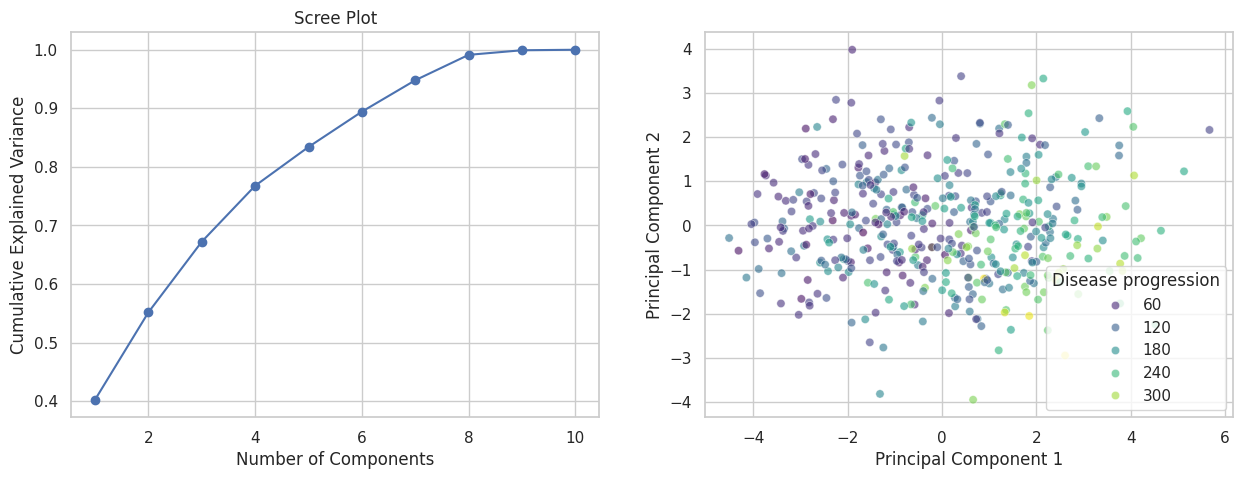

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns
sns.set_theme(style="whitegrid")

# 1. Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 2. Perform the PCA
pca = PCA()
pca.fit(X_std)

# 3. Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# 4. Project into PCA space
X_pca = pca.transform(X_std)

# 5. Plot the explained variance and 2D PCA projection
fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(np.arange(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
ax[0].set(xlabel='Number of Components', ylabel='Cumulative Explained Variance', title='Scree Plot')

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', alpha=0.6, ax=ax[1])
ax[1].set(xlabel='Principal Component 1', ylabel='Principal Component 2');

## Exercise 3.2: PCR and PLS

In this exercise, we will compare PCR and PLS on the classic Diabetes dataset from scikit-learn. This dataset contains 10 baseline variables (age, BMI, blood pressure, etc.) and a quantitative target: a measure of disease progression one year after baseline.

Start by loading the data and extracting the features (`X`) as well as the target (`y`):

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import matplotlib.pyplot as plt

data = load_diabetes(as_frame=True)
X = data.data
y = data.target

X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


How many predictors does the dataset have? Are any of them obviously correlated? Visualize them with a correlation matrix/heatmap.

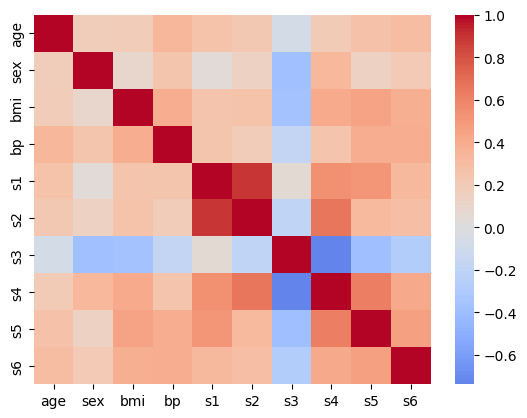

In [2]:
import seaborn as sns

sns.heatmap(X.corr(), cmap="coolwarm", center=0);

Please apply PCR with a range of component numbers to see how the performance changes.

1. Use 10-fold CV
2. Try 1 to 10 components
3. Create a model pipeline with `make_pipeline()`
4. Evaluate the models with `cross_val_score()`
5. Plot the $R^2$ over the components

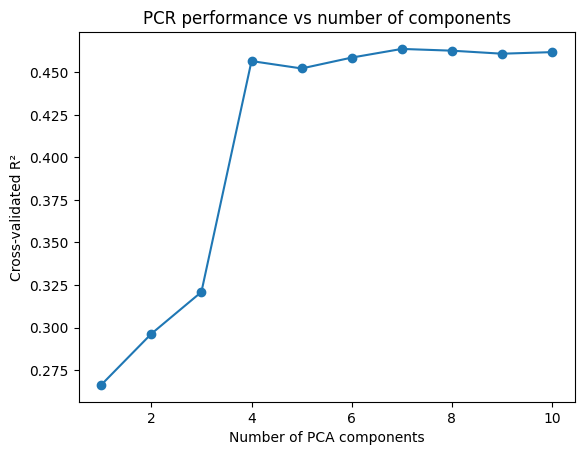

In [6]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

cv = KFold(n_splits=10)

n_components = np.arange(1, X.shape[1] + 1)
pcr_scores = []

for n in n_components:
    model = make_pipeline(StandardScaler(), PCA(n_components=n), LinearRegression())
    scores = cross_val_score(model, X, y, cv=cv, scoring="r2")
    pcr_scores.append(scores.mean())

# Plot
fig, ax = plt.subplots()
ax.plot(n_components, pcr_scores, marker="o")
ax.set(xlabel="Number of PCA components", ylabel="Cross-validated R²", title="PCR performance vs number of components");

Now, do the exact same thing with `PLSRegression`. How does PLS compare to PCR?

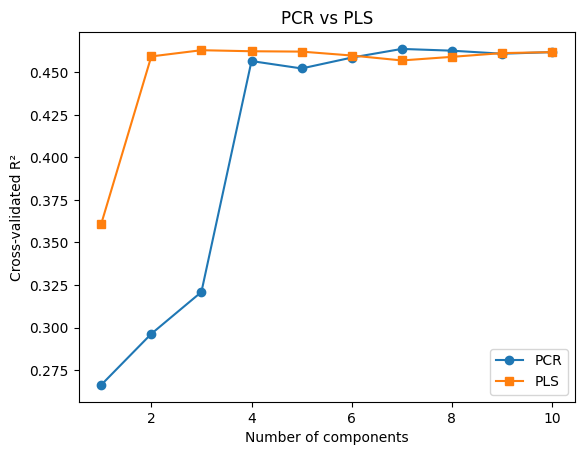

In [5]:
from sklearn.cross_decomposition import PLSRegression

pls_scores = []

for n in n_components:
    pls = PLSRegression(n_components=n)
    scores = cross_val_score(pls, X, y, cv=cv, scoring="r2")
    pls_scores.append(scores.mean())

# Plot
fig, ax = plt.subplots()
ax.plot(n_components, pcr_scores, marker="o", label="PCR")
ax.plot(n_components, pls_scores, marker="s", label="PLS")
ax.set(xlabel="Number of components", ylabel="Cross-validated R²", title="PCR vs PLS")
plt.legend();

## Exercise 4: Logistic Regression

For today's exercise we will use the **Breast Cancer Wisconsin (Diagnostic)**. It is a collection of data used for predicting whether a breast tumor is malignant (cancerous) or benign (non-cancerous), containing information derived from images of breast mass samples obtained through fine needle aspirates.

The dataset consists of 569 samples with 30 features that measure various characteristics of cell nuclei, such as radius, texture, perimeter, and area. Each sample is labeled as either **malignant (1)** or **benign (0)**.

1. Please [visit the documentation](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) and familiarize yourself with the dataset
2. Take an initial look at the features (predictors) and targets (outcomes)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from ucimlrepo import fetch_ucirepo

# Fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# Get data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

# Convert y to a 1D array (this is the required input for the logistic regression model)
y = np.ravel(y)

# Print some general information and statistics about the dataset 
print(breast_cancer_wisconsin_diagnostic.variables)
print(X.head())
print(X.describe())
print(y)

                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

Fitting the prediction model

1. Fit a logitic regression model using all predictors for predicting
2. Get and print the accuracy of the model.
3. Get and print the confusion matrix for the target variable.
4. Review the classification report and interpret the results.

*Hint: If you get a warning about convergence, try setting `max_iter=10000` in the logistic regression class.*

In [4]:
# Fit logistic regression model
model = LogisticRegression(max_iter=10000)
results = model.fit(X, y)

# Get the intercept and coefficients
intercept = results.intercept_
coef = results.coef_

print("Intercept:", intercept)
print("Coefficients:", coef)

# Evaluate the model using prediction accuracy
print("Model accuracy:", model.score(X, y))

# Print confusion Matrix
conf = confusion_matrix(y, model.predict(X))
print("Confusion matrix:\n", conf)

# Print classification report
from sklearn.metrics import classification_report
report = classification_report(y, model.predict(X))
print(report)

Intercept: [-27.95056684]
Coefficients: [[-1.01649102 -0.1801684   0.27565655 -0.0226662   0.1788688   0.22074883
   0.53685545  0.29603555  0.26639959  0.03046789  0.07816283 -1.25532588
  -0.11582457  0.10854792  0.02539334 -0.06767259  0.03651147  0.03822884
   0.03627027 -0.0140333  -0.15086497  0.43624862  0.10562901  0.01380557
   0.35772193  0.68749004  1.4271106   0.60399598  0.72848145  0.09506939]]
Model accuracy: 0.9578207381370826
Confusion matrix:
 [[348   9]
 [ 15 197]]
              precision    recall  f1-score   support

           B       0.96      0.97      0.97       357
           M       0.96      0.93      0.94       212

    accuracy                           0.96       569
   macro avg       0.96      0.95      0.95       569
weighted avg       0.96      0.96      0.96       569



1. Try to create a custom plot which visualizes the confusion matrix It should contain:
    - The four squares of the matrix (color coded)
    - Labels of the actual values in the middle of each square
    - Labels for all squares
    - A colorbar
    - A title

2. Use scikit-learn to do the same

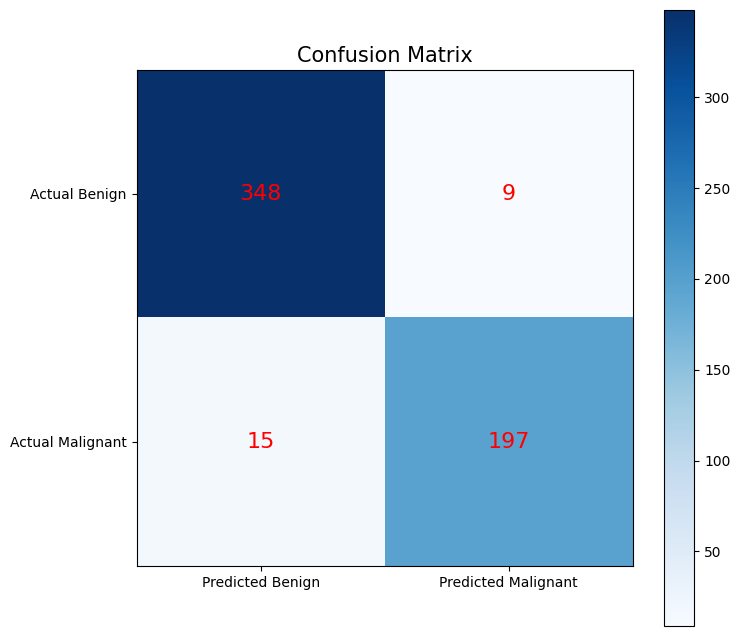

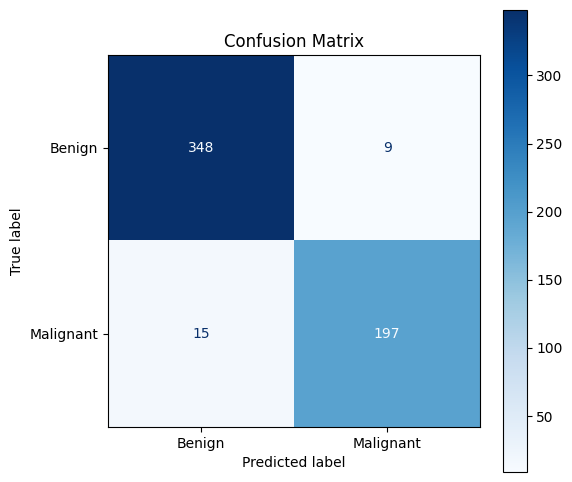

In [5]:
# 1. Plot a custom confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(conf, cmap='Blues')

# labels
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Benign', 'Predicted Malignant'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Benign', 'Actual Malignant'))

# Annotate the confusion matrix
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf[i, j], ha='center', va='center', color='red', fontsize=16)

ax.set_title('Confusion Matrix', fontsize=15)

plt.colorbar(cax)
plt.show()

# 2. Use scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix using scikit-learn
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                              display_labels=["Benign", "Malignant"])

disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Confusion Matrix")
plt.show()

## Exercise 5: LDA, QDA & Naïve Bayes

Once again, we will use the Iris dataset for classificationa analysis. Your task is to compare the performance of LDA, QDA, and Gaussian Naïve Bayes!

1. Load the `iris` dataset from `sklearn.datasets`. We will use only the first two features (sepal length and width)
2. `TODO:` Split the data into training and test sets ([use stratification!](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))
3. `TODO:` Fit LDA, QDA, and Naïve Bayes classifiers to the training data and orint the classification report for all models on the test data
4. Plot the decision boundaries for both models

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# 1. Load data
iris = load_iris()
X = iris.data[:, :2]
y = iris.target
target_names = iris.target_names

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 3. TODO: Fit a LDA model and print the classification report
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print(classification_report(y_test, lda.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.69      0.60      0.64        15
           2       0.65      0.73      0.69        15

    accuracy                           0.78        45
   macro avg       0.78      0.78      0.78        45
weighted avg       0.78      0.78      0.78        45



In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# 3. TODO: Fit a QDA model and print the classification report
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print(classification_report(y_test, qda.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.73      0.53      0.62        15
           2       0.63      0.80      0.71        15

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.77        45
weighted avg       0.79      0.78      0.77        45



In [11]:
from sklearn.naive_bayes import GaussianNB

# 3. TODO: Fit a Gaussian Naive Bayes model and print the classification report
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print(classification_report(y_test, gnb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.71      0.67      0.69        15
           2       0.69      0.73      0.71        15

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.80      0.80      0.80        45



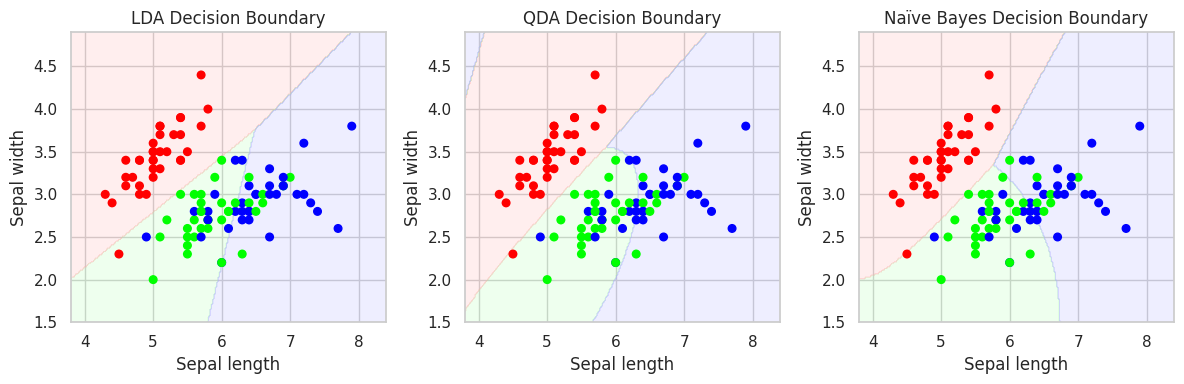

In [12]:
# 4. Plot the decision boundaries for all 3 classifiers

# Plotting function
def plot_decision_boundary(model, X, y, title, ax):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=30)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

# Create plots for all 3 classifiers
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_decision_boundary(lda, X_train, y_train, "LDA Decision Boundary", axes[0])
plot_decision_boundary(qda, X_train, y_train, "QDA Decision Boundary", axes[1])
plot_decision_boundary(gnb, X_train, y_train, "Naïve Bayes Decision Boundary", axes[2])
plt.tight_layout()